## Four-class classification
I added **bacteria pneumonia** images and use ResNet50 to build a three-class classifier

## Acknowledgement

Most of the code here is based on [this notebook](https://www.kaggle.com/dabawse/covid-19-classification-with-resnet50) by Jeebz.

## 04-16
* DenseNet
## 04-11
* Augmentor
* Select images of bacteria from each patients

In [1]:
import torch
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import warnings

import os
import itertools
import glob
import shutil
warnings.filterwarnings('ignore')

In [2]:
import random

In [3]:
!pip install Augmentor


In [4]:
import Augmentor

## Data Preprossessing

In [5]:
# ## count the number of bacteria
# num_bacteria = 0
# for phase in ['train', 'test', 'val']:
#     for i in os.listdir('/kaggle/input/chest-xray-pneumonia/chest_xray/' + phase + '/PNEUMONIA/'):
#         if i.split('_')[1] == 'bacteria':
#             num_bacteria+=1
# print('number of bacteria images: ', num_bacteria)



In [6]:
## check images in the COVID radiography dataset
covid_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/COVID/'
normal_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Normal/'
viral_path = '../input/covid19-radiography-database/COVID-19_Radiography_Dataset/Viral Pneumonia/'

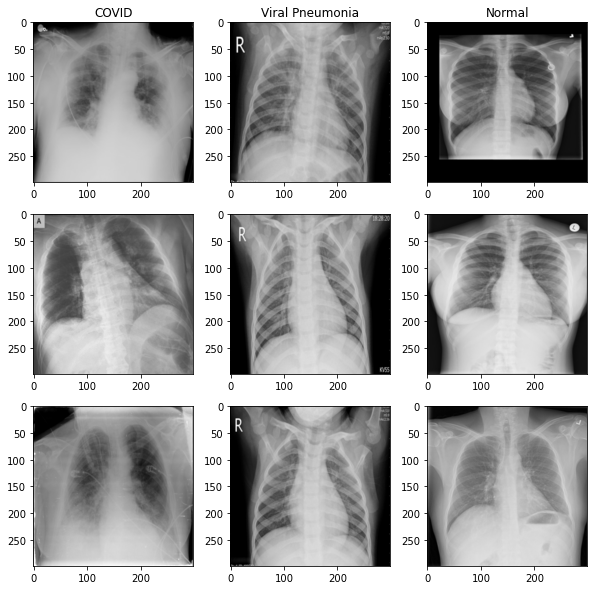

In [7]:
fig, axes = plt.subplots(3, 3, figsize=(10, 10))
labels = ['Covid', 'Normal', 'Pneumonia']
axes[0][0].imshow(cv2.imread(covid_path + 'COVID-1.png'))
axes[0][0].set_title('COVID')
axes[1][0].imshow(cv2.imread(covid_path + 'COVID-2.png'))
axes[2][0].imshow(cv2.imread(covid_path + 'COVID-3.png'))

axes[0][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-1.png'))
axes[0][1].set_title('Viral Pneumonia')
axes[1][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-2.png'))
axes[2][1].imshow(cv2.imread(viral_path +'Viral Pneumonia-3.png'))

axes[0][2].imshow(cv2.imread(normal_path+'Normal-1.png'))
axes[0][2].set_title('Normal')
axes[1][2].imshow(cv2.imread(normal_path+'Normal-2.png'))
axes[2][2].imshow(cv2.imread(normal_path+'Normal-3.png'));


In [8]:
## making directories
os.mkdir('/kaggle/working/train')
os.mkdir('/kaggle/working/test')
os.mkdir('/kaggle/working/valid')

os.mkdir('/kaggle/working/train/covid')
os.mkdir('/kaggle/working/test/covid')
os.mkdir('/kaggle/working/valid/covid')


os.mkdir('/kaggle/working/train/normal')
os.mkdir('/kaggle/working/test/normal')
os.mkdir('/kaggle/working/valid/normal')

os.mkdir('/kaggle/working/train/viral')
os.mkdir('/kaggle/working/test/viral')
os.mkdir('/kaggle/working/valid/viral')

os.mkdir('/kaggle/working/train/bacterial')
os.mkdir('/kaggle/working/test/bacterial')
os.mkdir('/kaggle/working/valid/bacterial')


In [9]:
## making directories for Augmentor 
## these files will be deleted in the end
os.mkdir('/kaggle/working/train_src')
os.mkdir('/kaggle/working/test_src')
os.mkdir('/kaggle/working/valid_src')


os.mkdir('/kaggle/working/train_src/covid')
os.mkdir('/kaggle/working/test_src/covid')
os.mkdir('/kaggle/working/valid_src/covid')

os.mkdir('/kaggle/working/train_src/normal')
os.mkdir('/kaggle/working/test_src/normal')
os.mkdir('/kaggle/working/valid_src/normal')

os.mkdir('/kaggle/working/train_src/viral')
os.mkdir('/kaggle/working/test_src/viral')
os.mkdir('/kaggle/working/valid_src/viral')

os.mkdir('/kaggle/working/train_src/bacterial')
os.mkdir('/kaggle/working/test_src/bacterial')
os.mkdir('/kaggle/working/valid_src/bacterial')

In [10]:
## move bacteria to one folder
os.mkdir('/kaggle/working/bacteria_merge/')


In [11]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

0

In [12]:
# files = glob.glob('/kaggle/working/bacteria_merge/*')
# for f in files:
#     os.remove(f)

In [13]:
## copy model to the required directory for bacteria images
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/train/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':

        shutil.copy(img, '/kaggle/working/bacteria_merge/')
        
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/test/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':
        #print(img.split('/')[-1].split('_')[1])

        shutil.copy(img, '/kaggle/working/bacteria_merge/')
        
pneu_path = '/kaggle/input/chest-xray-pneumonia/chest_xray/val/PNEUMONIA/'
len_pneu_path = len(os.listdir(pneu_path))
for img in itertools.islice(glob.iglob(os.path.join(pneu_path, '*.jpeg')), len_pneu_path):
    if img.split('/')[-1].split('_')[1] == 'bacteria':
        #print(img.split('/')[-1].split('_')[1])

        shutil.copy(img, '/kaggle/working/bacteria_merge/')

In [14]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

2780

In [15]:
patient_list = [int(i.split("_")[0][6:]) for i in os.listdir('/kaggle/working/bacteria_merge/')]

In [16]:
len(np.unique(patient_list)), len(patient_list)

(1437, 2780)

In [17]:
selected_list = []
for p in np.unique(patient_list):
    matched_files = [i for i in os.listdir('/kaggle/working/bacteria_merge/') if int(i.split("_")[0][6:])==p]
    if len(matched_files) ==1:
        selected_list.append('/kaggle/working/bacteria_merge/' + matched_files[0])
    else:
        #print('more')
        selected_file = random.choice(matched_files)
        #print(len(selected_file))
        selected_list.append('/kaggle/working/bacteria_merge/' + selected_file)
## delete unnecessary file


In [18]:
len(selected_list)

1437

In [19]:
files = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')
for f in files:
    #print(f)
    if f not in selected_list:
        os.remove(f)

In [20]:
len(os.listdir('/kaggle/working/bacteria_merge/'))

1437

In [21]:
## convert to jpg
jpgs = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')

for j in jpgs:
    img = cv2.imread(j)
    cv2.imwrite(j[:-4] + 'png', img)
## remove jpeg
files = glob.glob('/kaggle/working/bacteria_merge/*.jpeg')
for f in files:
    os.remove(f)
len(os.listdir('/kaggle/working/bacteria_merge/'))

1437

In [22]:
bacterial_path = '/kaggle/working/bacteria_merge/'

In [23]:
## decide length for each set
covid_train_len = int(np.floor(len(os.listdir(covid_path))*0.5))
covid_len = len(os.listdir(covid_path))

normal_train_len = int(np.floor(len(os.listdir(normal_path))*0.5))
normal_len = len(os.listdir(normal_path))

viral_train_len = int(np.floor(len(os.listdir(viral_path))*0.5))
viral_len = len(os.listdir(viral_path))

bacterial_train_len = int(np.floor(len(os.listdir(bacterial_path))*.5))
bacterial_len = len(os.listdir(bacterial_path))
print('COVID dataset length: ', covid_len, ' Normal dataset length: ', normal_len, ' Viral dataset length: ', viral_len, \
     'bacterial dataste length', bacterial_len)

COVID dataset length:  3616  Normal dataset length:  10192  Viral dataset length:  1345 bacterial dataste length 1437


In [24]:
random.seed(88)

In [25]:
for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(viral_path, '*.png')), key=lambda k: random.random()), viral_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/viral')

for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(covid_path, '*.png')),key=lambda k: random.random()), covid_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/covid')
    
for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(normal_path, '*.png')),key=lambda k: random.random()), normal_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/normal')

for trainimg in itertools.islice(sorted(glob.iglob(os.path.join(bacterial_path, '*.png')),key=lambda k: random.random()), bacterial_train_len):
    shutil.copy(trainimg, '/kaggle/working/train_src/bacterial/')
    
for testimg in itertools.islice(sorted(glob.iglob(os.path.join(covid_path, '*.png')),key=lambda k: random.random()), covid_train_len, covid_len):
    shutil.copy(testimg, '/kaggle/working/test_src/covid')

for testimg in itertools.islice(sorted(glob.iglob(os.path.join(normal_path, '*.png')),key=lambda k: random.random()), normal_train_len, normal_len):
    shutil.copy(testimg, '/kaggle/working/test_src/normal')

for testimg in itertools.islice(sorted(glob.iglob(os.path.join(viral_path, '*.png')), key=lambda k: random.random()),viral_train_len, viral_len):
    shutil.copy(testimg, '/kaggle/working/test_src/viral')
    
for testimg in itertools.islice(sorted(glob.iglob(os.path.join(bacterial_path, '*.png')),key=lambda k: random.random()),bacterial_train_len, bacterial_len):
    shutil.copy(testimg, '/kaggle/working/test_src/bacterial/')

In [26]:
random.seed(3)

In [27]:
for validimg in os.listdir('/kaggle/working/train_src/viral/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/viral/' + validimg, '/kaggle/working/valid_src/viral/')
        
for validimg in os.listdir('/kaggle/working/train_src/bacterial/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/bacterial/' + validimg, '/kaggle/working/valid_src/bacterial/')
        
for validimg in os.listdir('/kaggle/working/train_src/covid/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/covid/' + validimg, '/kaggle/working/valid_src/covid/')
        
for validimg in os.listdir('/kaggle/working/train_src/normal/'):
    if np.random.rand(1) < 0.2:
        shutil.move('/kaggle/working/train_src/normal/' + validimg, '/kaggle/working/valid_src/normal/')

In [28]:
len(os.listdir('/kaggle/working/train_src/normal/')), len(os.listdir('/kaggle/working/test_src/normal/')), len(os.listdir('/kaggle/working/valid_src/normal'))

(4032, 5096, 1064)

In [29]:
## augmentor
## Process covid directory first
p = Augmentor.Pipeline()
p.add_further_directory(new_source_directory='/kaggle/working/train_src/covid/', new_output_directory='/kaggle/working/train/covid/')
p.resize(width=244, height=244, probability=1)
p.crop_centre(probability=.1, percentage_area=.9)
p.resize(width=244, height=244, probability=1)
p.zoom_random(probability=.1, percentage_area=.8)

p.sample(3000)

Executing Pipeline:   0%|          | 0/3000 [00:00<?, ? Samples/s]

Initialised with 1437 image(s) found.
Output directory set to /kaggle/working/train/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF20208D10>: 100%|██████████| 3000/3000 [00:38<00:00, 78.28 Samples/s]


In [30]:
## test dir 
p2 = Augmentor.Pipeline()
p2.add_further_directory(new_source_directory='/kaggle/working/test_src/covid/', new_output_directory='/kaggle/working/test/covid/')
p2.resize(width=244, height=244, probability=1)
p2.crop_centre(probability=.1, percentage_area=.9)
p2.resize(width=244, height=244, probability=1)

p2.process()

## valid dir
p3 = Augmentor.Pipeline()
p3.add_further_directory(new_source_directory='/kaggle/working/valid_src/covid/', new_output_directory='/kaggle/working/valid/covid/')
p3.resize(width=244, height=244, probability=1)
p3.crop_centre(probability=.1, percentage_area=.9)
p3.resize(width=244, height=244, probability=1)

p3.process()

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF21A28050>:   0%|          | 0/1808 [00:00<?, ? Samples/s]

Initialised with 1808 image(s) found.
Output directory set to /kaggle/working/test/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF21E03690>: 100%|██████████| 1808/1808 [00:22<00:00, 81.74 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF21A7A590>:   2%|▏         | 9/371 [00:00<00:39,  9.06 Samples/s]

Initialised with 371 image(s) found.
Output directory set to /kaggle/working/valid/covid/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF21BA4F90>: 100%|██████████| 371/371 [00:04<00:00, 82.92 Samples/s]


In [31]:
## other directory are the same
for category in ['bacterial', 'viral', 'normal']:
    ## train
    p = Augmentor.Pipeline()
    p.add_further_directory(new_source_directory='/kaggle/working/train_src/' + category + '/', new_output_directory='/kaggle/working/train/' + category + '/')
    p.resize(width=244, height=244, probability=1)
    p.crop_centre(probability=.1, percentage_area=.9)
    p.resize(width=244, height=244, probability=1)
    p.zoom_random(probability=.1, percentage_area=.8)

    p.process()
    
    ## test
    p2 = Augmentor.Pipeline()
    p2.add_further_directory(new_source_directory='/kaggle/working/test_src/' + category + '/', new_output_directory='/kaggle/working/test/' + \
                             category + '/')
    p2.resize(width=244, height=244, probability=1)
    p2.crop_centre(probability=.1, percentage_area=.9)
    p2.resize(width=244, height=244, probability=1)
    
    p2.process()
    
    ## valid
    p3 = Augmentor.Pipeline()
    p3.add_further_directory(new_source_directory='/kaggle/working/valid_src/' + category + '/', new_output_directory='/kaggle/working/valid/' + category+ '/')
    p3.resize(width=244, height=244, probability=1)
    p3.crop_centre(probability=.1, percentage_area=.9)
    p3.resize(width=244, height=244, probability=1)
    
    p3.process()

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7FEF201E8390>:   0%|          | 1/580 [00:00<01:20,  7.21 Samples/s]

Initialised with 580 image(s) found.
Output directory set to /kaggle/working/train/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7FEF202FA590>: 100%|██████████| 580/580 [00:24<00:00, 24.05 Samples/s]
Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7FEF21A627D0>:   0%|          | 1/719 [00:00<01:24,  8.54 Samples/s]

Initialised with 719 image(s) found.
Output directory set to /kaggle/working/test/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7FEF202FABD0>: 100%|██████████| 719/719 [00:31<00:00, 22.56 Samples/s]
Executing Pipeline:   0%|          | 0/138 [00:00<?, ? Samples/s]

Initialised with 138 image(s) found.
Output directory set to /kaggle/working/valid/bacterial/.

Processing <PIL.Image.Image image mode=RGB size=244x244 at 0x7FEF20430490>: 100%|██████████| 138/138 [00:05<00:00, 23.68 Samples/s]
Executing Pipeline:   0%|          | 0/544 [00:00<?, ? Samples/s]

Initialised with 544 image(s) found.
Output directory set to /kaggle/working/train/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF20324190>: 100%|██████████| 544/544 [00:06<00:00, 82.88 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF20324690>:   1%|          | 8/673 [00:00<01:21,  8.14 Samples/s]

Initialised with 673 image(s) found.
Output directory set to /kaggle/working/test/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF20443F50>: 100%|██████████| 673/673 [00:08<00:00, 81.56 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF216B5A50>:   9%|▉         | 12/128 [00:00<00:04, 25.77 Samples/s]

Initialised with 128 image(s) found.
Output directory set to /kaggle/working/valid/viral/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF202FADD0>: 100%|██████████| 128/128 [00:01<00:00, 84.52 Samples/s]
Executing Pipeline:   0%|          | 0/4032 [00:00<?, ? Samples/s]

Initialised with 4032 image(s) found.
Output directory set to /kaggle/working/train/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF185D4AD0>: 100%|██████████| 4032/4032 [00:49<00:00, 80.66 Samples/s]
Executing Pipeline:   0%|          | 0/5096 [00:00<?, ? Samples/s]

Initialised with 5096 image(s) found.
Output directory set to /kaggle/working/test/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF20430390>: 100%|██████████| 5096/5096 [01:03<00:00, 80.68 Samples/s]
Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF21A68BD0>:   1%|          | 6/1064 [00:00<02:15,  7.78 Samples/s]

Initialised with 1064 image(s) found.
Output directory set to /kaggle/working/valid/normal/.

Processing <PIL.Image.Image image mode=L size=244x244 at 0x7FEF186E1750>: 100%|██████████| 1064/1064 [00:12<00:00, 85.84 Samples/s]


In [32]:
## remove all the train_src dir


files = glob.glob('/kaggle/working/train_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/test_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/valid_src/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/bacteria_merge/*.png')
for f in files:
    os.remove(f)

In [33]:
normalizer = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
#normalizer = transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.25, 0.25, 0.25])
data_transforms = {
    'train': transforms.Compose([
        #p.torch_transform(),
        transforms.ToTensor(),
        normalizer
    ]),
    'validation': transforms.Compose([
        #p2.torch_transform(),
        transforms.ToTensor(),
        normalizer
    ])
}

In [34]:
data_images = {
    'train': datasets.ImageFolder('/kaggle/working/train', data_transforms['train']),
    'validation': datasets.ImageFolder('/kaggle/working/test', data_transforms['validation'])
}

In [35]:
data_images['train'].class_to_idx

{'bacterial': 0, 'covid': 1, 'normal': 2, 'viral': 3}

In [36]:
data_images['train']

Dataset ImageFolder
    Number of datapoints: 8156
    Root location: /kaggle/working/train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
           )

In [37]:
dataloaders = {
    'train': torch.utils.data.DataLoader(data_images['train'], batch_size=32, shuffle=True, num_workers=0),
    'validation': torch.utils.data.DataLoader(data_images['validation'], batch_size=32,shuffle=True,num_workers=0)
}

In [38]:
testloaders = {
    'test': torch.utils.data.DataLoader(datasets.ImageFolder('/kaggle/working/test/', data_transforms['validation']), \
                                       batch_size=32, shuffle=False, num_workers=0)
}

In [39]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
#model = models.resnet50(pretrained=True).cuda()

In [40]:
class DensNet(nn.Module):
    def __init__(self, num_classes=4, num_channels=3):
        super().__init__()
        preloaded = models.densenet121(pretrained=True)
        self.features = preloaded.features
        self.features.conv0 = nn.Conv2d(num_channels, 64, 7, 2, 3)
        self.classifier = nn.Linear(1024, num_classes, bias=True)
        del preloaded
        
    def forward(self, x):
        features = self.features(x)
        out = F.relu(features, inplace=True)
        out = F.adaptive_avg_pool2d(out, (1, 1)).view(features.size(0), -1)
        out = self.classifier(out)
        return out

In [41]:
classes = 4
model = DensNet(num_classes=classes)
model.to(device);

Downloading: "https://download.pytorch.org/models/densenet121-a639ec97.pth" to /root/.cache/torch/hub/checkpoints/densenet121-a639ec97.pth


  0%|          | 0.00/30.8M [00:00<?, ?B/s]

In [42]:
# for param in model.parameters():
#     param.requires_grad = False

In [43]:
# model.fc = nn.Sequential(
#     nn.Linear(2048, 64),
#     nn.ReLU(inplace=True),
#     nn.Linear(64, 4) # change the last dimension
# ).to(device)

In [44]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 1e-3)

In [45]:
def trained_model(model, criterion, optimizer, epochs):
    loss_history, acc_history = [],[]
    for epoch in range(epochs):
        
        print('Epoch:', str(epoch+1) + '/' + str(epochs))
        print('-'*10)
        conf_matrix = torch.zeros(4, 4)
        for phase in ['train', 'validation']:
            if phase == 'train':
                model.train() #this trains the model
            else:
                model.eval() #this evaluates the model

            running_loss, running_corrects = 0.0, 0 
            
            ## adding Y_test and Y_pred
            Y_test=[]
            Y_pred=[]
            Y_pred_prob = []
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device) #convert inputs to cpu or cuda
                labels = labels.to(device) #convert labels to cpu or cuda

                outputs = model(inputs) #outputs is inputs being fed to the model
                loss = criterion(outputs, labels) #outputs are fed into the model

                if phase == 'train':
                    optimizer.zero_grad() #sets gradients to zero
                    loss.backward() #computes sum of gradients
                    optimizer.step() #preforms an optimization step

                #_, preds = torch.max(outputs, 1) #max elements of outputs with output dimension of one
                preds_soft = torch.softmax(outputs, dim=1)
                _, preds = torch.max(preds_soft, 1)
#                 print('output: ', outputs)
#                 print('preds soft: ', preds_soft)
#                 print('preds: ', preds)
                running_loss += loss.item() * inputs.size(0) #loss multiplied by the first dimension of inputs
                running_corrects += torch.sum(preds == labels.data) #sum of all the correct predictions
                
                ## print out
                #print("\npreds:", preds[:10])
                #print("label:", labels.data[:10])
                
                ## calculate sensitivity and specificity
                if phase == 'validation':
                    
                    for t, p in zip(labels.data, preds):
                        conf_matrix[t, p] += 1
                
                

                if phase=='validation' and epoch == epochs-1:
                    y_pred = preds.detach().cpu().numpy()
                    y_test = labels.data.detach().cpu().numpy()
                    y_pred_prob = preds_soft.detach().cpu().numpy()
                    
                    Y_pred_prob.append(y_pred_prob)
                    Y_test.append(y_test)
                    Y_pred.append(y_pred)
                
            epoch_loss = running_loss / len(data_images[phase]) #this is the epoch loss
            epoch_accuracy = running_corrects.double() / len(data_images[phase]) #this is the epoch accuracy

            print(phase, ' loss:', epoch_loss, 'epoch_accuracy:', epoch_accuracy)
            
            loss_history.append(epoch_loss)
            acc_history.append(epoch_accuracy)
            
            if phase == 'validation':
                # need to adjust the index based on the class index
                correct_covid_label = conf_matrix[1,1]
                total_covid_label = torch.sum(conf_matrix[1,:])
                correct_non_covid = conf_matrix[0,0] + conf_matrix[2,2] + conf_matrix[3,3]
                total_non_convid_label = torch.sum(conf_matrix[0,:]) + torch.sum(conf_matrix[2,:]) + torch.sum(conf_matrix[3,:])
                print('sensitivity: ', correct_covid_label/total_covid_label)
                print('specificity: ', correct_non_covid/total_non_convid_label)
    
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    Y_pred_prob =np.concatenate(Y_pred_prob, axis=0)
    
    return model, conf_matrix, Y_test, Y_pred, Y_pred_prob, loss_history, acc_history

In [46]:
model, mtrx, Y_test, Y_pred, Y_pred_prob, loss_his, acc_his = trained_model(model, criterion, optimizer, 20)


Epoch: 1/20
----------
train  loss: 0.4605137956177504 epoch_accuracy: tensor(0.8077, device='cuda:0', dtype=torch.float64)
validation  loss: 1.8369600154394814 epoch_accuracy: tensor(0.6117, device='cuda:0', dtype=torch.float64)
sensitivity:  tensor(0.9652)
specificity:  tensor(0.5133)
Epoch: 2/20
----------
train  loss: 0.2969661183571219 epoch_accuracy: tensor(0.8844, device='cuda:0', dtype=torch.float64)
validation  loss: 0.2700398897136074 epoch_accuracy: tensor(0.8872, device='cuda:0', dtype=torch.float64)
sensitivity:  tensor(0.9248)
specificity:  tensor(0.8767)
Epoch: 3/20
----------
train  loss: 0.27018428867561317 epoch_accuracy: tensor(0.8948, device='cuda:0', dtype=torch.float64)
validation  loss: 1.6600758498292074 epoch_accuracy: tensor(0.6854, device='cuda:0', dtype=torch.float64)
sensitivity:  tensor(0.9010)
specificity:  tensor(0.6253)
Epoch: 4/20
----------
train  loss: 0.21510664283381542 epoch_accuracy: tensor(0.9131, device='cuda:0', dtype=torch.float64)
validation

In [47]:
Y_pred_prob[:,1]

array([4.1698892e-10, 1.1219871e-11, 5.6418835e-11, ..., 3.1432368e-08,
       2.6499786e-06, 3.6575695e-04], dtype=float32)

In [48]:
Y_test

array([2, 2, 2, ..., 2, 3, 2])

In [49]:
Y_pred

array([2, 2, 2, ..., 2, 0, 2])

In [50]:
def eval_model(model, dataloader):

    model.eval()
    Y_pred = []
    Y_test = []
    Y_pred_prob = []
    for data, target in dataloader:
        # your code here
        #raise NotImplementedError
        data = data.to(device)
        output = model(data)
        preds_soft = torch.softmax(output, dim=1)
        _, preds = torch.max(preds_soft, 1)
        y_pred = preds.detach().cpu().numpy()
        Y_pred.append(y_pred)
        
        y_test = target.data.detach().cpu().numpy()
        Y_test.append(y_test)
        
        y_pred_prob = preds_soft.detach().cpu().numpy()
        Y_pred_prob.append(y_pred_prob)
        #print(target)
        #print(Y_pred[0].shape)
    Y_pred = np.concatenate(Y_pred, axis=0)
    Y_test = np.concatenate(Y_test, axis=0)
    Y_pred_prob = np.concatenate(Y_pred_prob, axis=0)
    return Y_pred, Y_test, Y_pred_prob

In [51]:
Y_pred, Y_test, Y_pred_prob = eval_model(model, testloaders['test'])


In [52]:
Y_test_COVID = [1 if i ==1 else 0 for i in Y_test]
Y_pred_COVID = [1 if i == 1 else 0 for i in Y_pred]


In [53]:
#sensitivity= correct_covid_label/total_covid_label

total_covid_label = np.sum(Y_test_COVID)
total_non_covid = len(Y_test_COVID) - total_covid_label
correct_covid_label = 0
correct_non_covid = 0
for i, v in enumerate(Y_test_COVID):
    if v==1 and Y_pred_COVID[i] == v:
        correct_covid_label +=1
    elif v==0 and Y_pred_COVID[i] ==v:
        correct_non_covid +=1
    else:
        pass

sensitivity = correct_covid_label/total_covid_label
specificity = correct_non_covid/total_non_covid

print(sensitivity, specificity)

0.9596238938053098 0.9912145499383477


In [54]:
from sklearn.metrics import precision_recall_curve

In [55]:
prec, recall, c = precision_recall_curve(Y_test_COVID , Y_pred_prob[:,1])

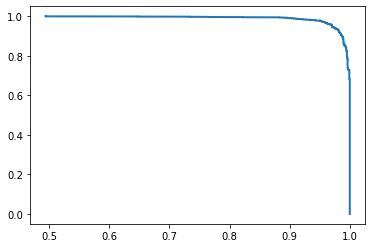

In [56]:
plt.plot(prec, recall, lw=2)

In [57]:
pd.DataFrame({'precision': prec, 'recall': recall}).to_csv('pc_curve_0420_densenet_zoom_1.csv', index=False)

In [58]:
df = pd.DataFrame({'precision': prec, 'recall': recall})

In [59]:
files = glob.glob('/kaggle/working/train/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/test/*/*.png')
for f in files:
    os.remove(f)
files = glob.glob('/kaggle/working/valid/*/*.png')
for f in files:
    os.remove(f)

In [60]:
acc_his

[tensor(0.8077, device='cuda:0', dtype=torch.float64),
 tensor(0.6117, device='cuda:0', dtype=torch.float64),
 tensor(0.8844, device='cuda:0', dtype=torch.float64),
 tensor(0.8872, device='cuda:0', dtype=torch.float64),
 tensor(0.8948, device='cuda:0', dtype=torch.float64),
 tensor(0.6854, device='cuda:0', dtype=torch.float64),
 tensor(0.9131, device='cuda:0', dtype=torch.float64),
 tensor(0.8905, device='cuda:0', dtype=torch.float64),
 tensor(0.9177, device='cuda:0', dtype=torch.float64),
 tensor(0.9236, device='cuda:0', dtype=torch.float64),
 tensor(0.9190, device='cuda:0', dtype=torch.float64),
 tensor(0.9184, device='cuda:0', dtype=torch.float64),
 tensor(0.9339, device='cuda:0', dtype=torch.float64),
 tensor(0.8925, device='cuda:0', dtype=torch.float64),
 tensor(0.9366, device='cuda:0', dtype=torch.float64),
 tensor(0.9126, device='cuda:0', dtype=torch.float64),
 tensor(0.9421, device='cuda:0', dtype=torch.float64),
 tensor(0.9069, device='cuda:0', dtype=torch.float64),
 tensor(0.

In [61]:
loss_his

[0.4605137956177504,
 1.8369600154394814,
 0.2969661183571219,
 0.2700398897136074,
 0.27018428867561317,
 1.6600758498292074,
 0.21510664283381542,
 0.2665821806659694,
 0.20075076560856608,
 0.18735458365602917,
 0.19016143727258336,
 0.19837108628398656,
 0.1657534571014648,
 0.26182125929990924,
 0.1482753192712683,
 0.2136791170347507,
 0.13998038639269253,
 0.22178782980346634,
 0.13311739820418783,
 0.2405437425267501,
 0.1454474032473307,
 0.15037395571975493,
 0.11623037066411131,
 0.20586753719582393,
 0.12376563030132012,
 0.16374071255297531,
 0.0953600906683365,
 0.18327857142273002,
 0.10603229490863804,
 0.16360336955319713,
 0.0932144686057177,
 0.19812173696850915,
 0.08342815539696861,
 0.16657188623647853,
 0.07685580085131717,
 0.17746631536101104,
 0.0830852271337656,
 0.14608938277590383,
 0.049581850408893874,
 0.1691220884131431]

In [62]:
mtrx

tensor([[5.7200e+02, 0.0000e+00, 5.0000e+00, 1.4200e+02],
        [1.0000e+01, 1.7350e+03, 4.5000e+01, 1.8000e+01],
        [7.0000e+00, 5.7000e+01, 5.0020e+03, 3.0000e+01],
        [1.5800e+02, 0.0000e+00, 1.3000e+01, 5.0200e+02]])

In [63]:
acc_hist = [i.detach().cpu().numpy() for i in acc_his]

In [64]:
acc_hist

[array(0.8077489),
 array(0.6117406),
 array(0.8843796),
 array(0.88717454),
 array(0.89480137),
 array(0.68539055),
 array(0.91307013),
 array(0.89054966),
 array(0.91772928),
 array(0.92357763),
 array(0.91895537),
 array(0.91839441),
 array(0.93391368),
 array(0.8924783),
 array(0.93661108),
 array(0.91260849),
 array(0.94212849),
 array(0.90694311),
 array(0.94323198),
 array(0.91164417),
 array(0.93881805),
 array(0.93804243),
 array(0.9542668),
 array(0.91996143),
 array(0.95107896),
 array(0.93044841),
 array(0.96395292),
 array(0.92912247),
 array(0.95953899),
 array(0.93165381),
 array(0.96088769),
 array(0.92743491),
 array(0.96530162),
 array(0.94394889),
 array(0.97008337),
 array(0.93864513),
 array(0.96750858),
 array(0.94877049),
 array(0.98062776),
 array(0.94153809)]

In [65]:
train_loss

NameError: name 'train_loss' is not defined

In [66]:
val_loss

NameError: name 'val_loss' is not defined

In [67]:
train_acc

NameError: name 'train_acc' is not defined

In [68]:
val_acc

NameError: name 'val_acc' is not defined